<a href="https://colab.research.google.com/github/guard1000/SKT_AI_WG/blob/master/wg_text_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [ ]:
# 엑셀파일 읽어오는 코드. 아래 주소는 엑셀파일의 주소로 변경하세요!
#  -- ex) 엑셀파일이 같은 폴더에 있다면, pd.read_excel("wg_data.xlsx", sheet_name='Sheet1') 
vocs = pd.read_excel("/content/drive/My Drive/data/wg_data.xlsx", sheet_name='Sheet1')
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질%^&^& 및 데이터 끊김 발생됨.,데이터품질
1,[원클릭-양호] -실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,[원클릭-문의 ] 현기 1. 상세증상: 원래 괜찮았는데 일@#@@@@_+주일안쪽으로...,데이터품질
3,"' [CE진단-양호] 시설공급 1. 상세증상: 안테나 2칸 데이터 접속 느림,끊...",데이터품질
4,[원클릭-문의] -일주%^&^&일전부터 -안테나 안뜨거나 3G 변경되며 음질 끊...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 ########$안된다고 함 다른데로 이동은 ...,음성품질
106,CE진단결과 양호 (W- 품질개선가능여부) 1. 상세증상 : 집안에서도 절반정도 통...,음성품질
107,(C- 특이사항) 1. 상세증상 : - 몇개월전부터/ 수신실패/위치무관/ 2....,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 전처리 - []으로 시작하는거 제거, 상세증상, 특수문자 제거, 용어 변환, 레이블 숫자변환, 셔플
# Data Visualise -  레이블별 분포, 평균길이 등
# 토큰화 - konlpy okt 사용해서 태그 달아주기 -> 명사, 동사만 남기고 다 제거!
# 인덱싱 - 사전 만들기 및 사전표현하기

# **전처리 예시**

In [ ]:
# 1. 개행문자 제거 (Slicing)
#    memo 들을 보면 [원클릭-양호] [CE진단-양호] 와 같이 시작하는 녀석들이 존재합니다
#    이 친구들은 실제 메모 내용에 별 의미 없을테니 제거해줍시다.

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  if memos[_][:3].find('[') != -1: # 문장의 앞 3 문자 중 '[' 이 존재한다면
    start =  memos[_].find(']')      # 문장의 ']' 위치를 새로운 시작점으로 변경 
    memos[_] = memos[_][start+1:]    # 텍스트 슬라이싱

vocs['memo'] = memos                 # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질%^&^& 및 데이터 끊김 발생됨.,데이터품질
1,-실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,현기 1. 상세증상: 원래 괜찮았는데 일@#@@@@_+주일안쪽으로 자택에서@#@@...,데이터품질
3,"시설공급 1. 상세증상: 안테나 2칸 데이터 접속 느림,끊김 타사사용자는 양...",데이터품질
4,-일주%^&^&일전부터 -안테나 안뜨거나 3G 변경되며 음질 끊김 -데이터도 ...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 ########$안된다고 함 다른데로 이동은 ...,음성품질
106,CE진단결과 양호 (W- 품질개선가능여부) 1. 상세증상 : 집안에서도 절반정도 통...,음성품질
107,(C- 특이사항) 1. 상세증상 : - 몇개월전부터/ 수신실패/위치무관/ 2....,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 2. 상세증상 추출 (Slicing)
#    memo 들을 보면 '1.상세증상': ~  와 같은 포맷에 맞춘 메모들이 심심찮게 보입니다.
#    상담유형을 분류하는데 상세증상이 핵심이고, 다른 내용은 noise 이므로 이런 포맷의 메모는
#    상세증상에 해당하는 내용만 추출해 줍시다.

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  if memos[_].find('상세증상') != -1:         # 문장에 '상세증상' 이 포함되 있다면
    start =  memos[_].find('상세증상')        # 문장의 '상세증상' 위치를 새로운 시작점으로 변경
    end = memos[_].find('2.')                   # 보통 위 포맷이 1. 상세증상 ~~ 2. ~~~ 이런 유형이기에... 2 전까지! 
    memos[_] = memos[_][start+5:end]      # 텍스트 슬라이싱

vocs['memo'] = memos                   # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질%^&^& 및 데이터 끊김 발생됨.,데이터품질
1,-실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,원래 괜찮았는데 일@#@@@@_+주일안쪽으로 자택에서@#@@@@_+만 단말기에서 ...,데이터품질
3,"안테나 2칸 데이터 접속 느림,끊김 타사사용자는 양호 음성통화 정상 단말...",데이터품질
4,-일주%^&^&일전부터 -안테나 안뜨거나 3G 변경되며 음질 끊김 -데이터도 ...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 ########$안된다고 함 다른데로 이동은 ...,음성품질
106,: 집안에서도 절반정도 통화안되는내용으로 품질확인요청,음성품질
107,: - 몇개월전부터/ 수신실패/위치무관/,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 3. 특수문자 제거 (정규식)
#    memo 들을 보면 '@#@@@@_+', '########$'와 같은 특수문자 noise가 보입니다. 
#    특수문자는 메모 내용을 파악하는데 noise이므로, 정규식을 활용해 정제해 줍시다

pattern_ex = '[~!@#$%^&*()_+-/:;]' # 이 외에도 지울 대상 변경가능!

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  memos[_] = re.sub(pattern_ex,'',memos[_])  

vocs['memo'] = memos                   # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질 및 데이터 끊김 발생됨,데이터품질
1,실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,원래 괜찮았는데 일주일안쪽으로 자택에서만 단말기에서 LTE라고 떠도 LTE 속도가...,데이터품질
3,안테나 2칸 데이터 접속 느림끊김 타사사용자는 양호 음성통화 정상 단말기...,데이터품질
4,일주일전부터 안테나 안뜨거나 3G 변경되며 음질 끊김 데이터도 잘 안됨 네...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 안된다고 함 다른데로 이동은 못해봐서 다른곳은...,음성품질
106,집안에서도 절반정도 통화안되는내용으로 품질확인요청,음성품질
107,몇개월전부터 수신실패위치무관,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 4. 용어 치환 (정규식)
#    불용어(stopword) 제거 및 용어 치환 등에 활용합니다.
#    예를들어, '3G'나 'LTE', '5G' 와 같은 단어들은 결국 유형을 분류하는 목적에서 보면 비슷한 의미이며, 
#    다양한 용어로 표현하기보단 단순하게 표현하는 것이 더 좋은 성능을 보일 수 있습니다.
#    예시로 모두 LTE로 치환시켜 보겠습니다.

pattern_ex = ['3G','5G']

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  for pat_ex in pattern_ex:
    memos[_] = re.sub(pat_ex,'LTE',memos[_]) 

vocs['memo'] = memos                   # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs    

,memo,label
0,자택과 직장에서 장소상관없이 음질 및 데이터 끊김 발생됨,데이터품질
1,실내외 왔다갔다하면 LTE와 LTE번갈아 잡혀 불량,데이터품질
2,원래 괜찮았는데 일주일안쪽으로 자택에서만 단말기에서 LTE라고 떠도 LTE 속도가...,데이터품질
3,안테나 2칸 데이터 접속 느림끊김 타사사용자는 양호 음성통화 정상 단말기...,데이터품질
4,일주일전부터 안테나 안뜨거나 LTE 변경되며 음질 끊김 데이터도 잘 안됨 ...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 안된다고 함 다른데로 이동은 못해봐서 다른곳은...,음성품질
106,집안에서도 절반정도 통화안되는내용으로 품질확인요청,음성품질
107,몇개월전부터 수신실패위치무관,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 5. label명 숫자 치환
#    label명이 지금은 '데이터품질' 과 같은 한글인데요. 숫자로 바꿔주겠습니다.

label_dict = {'데이터품질': 0, '영상품질':1, '음성품질':2}

labels = list(vocs['label']) # 메모만 불러와서
for _ in range(len(labels)):
  labels[_] = label_dict[labels[_]]

vocs['label'] = labels                   # vocs 의 label 컬럼을 전처리한 label로 대체
vocs  

,memo,label
0,자택과 직장에서 장소상관없이 음질 및 데이터 끊김 발생됨,0
1,실내외 왔다갔다하면 LTE와 LTE번갈아 잡혀 불량,0
2,원래 괜찮았는데 일주일안쪽으로 자택에서만 단말기에서 LTE라고 떠도 LTE 속도가...,0
3,안테나 2칸 데이터 접속 느림끊김 타사사용자는 양호 음성통화 정상 단말기...,0
4,일주일전부터 안테나 안뜨거나 LTE 변경되며 음질 끊김 데이터도 잘 안됨 ...,0
...,...,...
105,여기서 30분 전부터 갑자기 통화가 안된다고 함 다른데로 이동은 못해봐서 다른곳은...,2
106,집안에서도 절반정도 통화안되는내용으로 품질확인요청,2
107,몇개월전부터 수신실패위치무관,2
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,2


In [ ]:
# 6. Shuffle
#    지금은 데이터가 레이블별로 정렬되어 있습니다.
#    고른 학습을 위해 셔플을 해줍시다.

vocs = vocs.sample(frac=1)  # 셔플
vocs.reset_index(drop=True, inplace=True) # 셔플로 뒤죽박죽이 된 index를 reset해줍니다
vocs

,memo,label
0,번호이동후부터 위데이터도 버퍼링이 걸리면서 잘안됨,0
1,집에서 창가에 붙어야지만 통화가됨,2
2,오늘 아침부터 갑자기 데이터 이용 불가 문의 와이파이 끔 데이터 켜져있음 경고,0
3,갑자기 며칠전부터 영상통화 시 말소리가 안들린다고 함 해당주소지 품질 및 특이사...,1
4,데이터 접속 불량 안테나 감도가 2개정도 한달전부터 위치무관,0
...,...,...
105,몇개월전부터 수신실패위치무관,2
106,10일전부터 통화권이탈 단말점검 권유 후 종료,2
107,영상통화 불량 상대방은 양호한데 고객님화면은 깨짐 열흘전부터,1
108,기변후 데이터끊김현상,0


# **데이터 분포 확인 / Visualise**

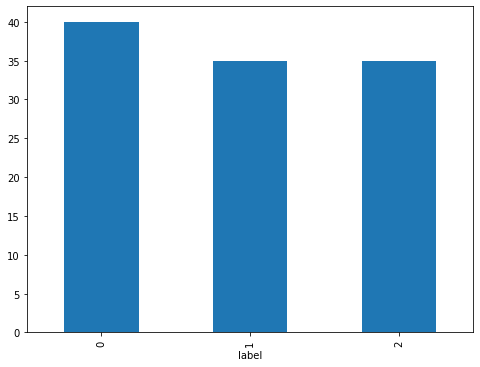

In [ ]:
# 1. 레이블별 분포 확인 
#    간단히 pyplot을 활용해 분포 시각화를 해봅니다.

fig = plt.figure(figsize = (8,6))     
vocs.groupby('label').memo.count().plot.bar(ylim=0)

VoC memo 최대 길이 : 165
VoC memo 평균 길이 : 49.663636363636364


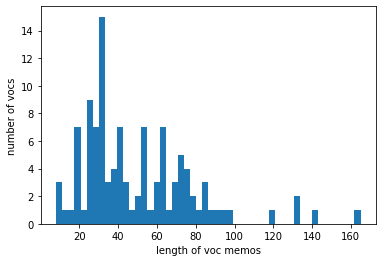

In [ ]:
# 2. 메모의 길이 시각화
#    간단히 pyplot을 활용해 메모의 길이에 대해 알아봅시다.

print('VoC memo 최대 길이 :',max(len(l) for l in vocs.memo))
print('VoC memo 평균 길이 :',sum(map(len, vocs.memo))/len(vocs.memo))
plt.hist([len(s) for s in vocs.memo], bins=50)
plt.xlabel('length of voc memos')
plt.ylabel('number of vocs')
plt.show()

In [ ]:
# 2-2. <참고> 메모의 특정 길이 이하의 비율은 얼마나 될까?
#      특정 길이 이하인 비율을 통해, 너무 아웃라이어인 데이터를
#      발라내는데 활용할 수 있습니다.

#      위 그래프를 통해 길이 100 미만의 비율이 궁금하면 아래와 같이 확인하고,
#      4.5% 정도의 아웃라이어는 활용하지 않는 등의 처리를 할 수 있습니다.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 데이터 중 길이가 %s 이하인 데이터의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 100  # 위 그래프 보면서 임의로 값 넣어보면서 비율 확인
below_threshold_len(max_len, vocs.memo)

전체 데이터 중 길이가 100 이하인 데이터의 비율: 95.45454545454545
